# out_fiberID
* 기존변수 + u-g,g-r,r-i,i-z만 추가변수로 사용
* fiber_ID를 제외하고 진행해봄
* 제출결과 : 0.4076887978
-> oversample자체가 다소 overfitting되는듯

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss


import lightgbm as lgb
from sklearn.model_selection import KFold

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [71]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

### oversampling

In [72]:
# 전부를 오버샘플링하지 않고 하위 5개만 오버샘플림을 징행한다
last5 = train_df.type.value_counts().tail().index
last5_df = train_df[train_df.type.apply(lambda x : x in last5)]
not_last5_df = train_df[train_df.type.apply(lambda x : x not in last5)]
not_last5_df.shape

(198136, 22)

In [73]:
last5_df.type.value_counts()

STAR_SUB_DWARF        1154
STAR_BROWN_DWARF       500
SKY                    127
SERENDIPITY_MANUAL      61
STAR_PN                 13
Name: type, dtype: int64

In [80]:
last5_df.head()

,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
id,,,,,,,,,,,,,,,,,,,,,,
130,STAR_BROWN_DWARF,307,24.000698,24.130331,22.397570,19.683266,17.899966,22.140558,23.953209,22.395944,20.004330,18.254870,23.335455,23.888990,22.326547,19.869744,17.979923,23.455427,24.435867,21.982169,19.627870,17.862923
178,STAR_SUB_DWARF,473,22.513232,20.303728,18.669804,17.335240,16.620192,22.980001,20.680711,18.988550,17.660633,16.957475,22.713534,20.378224,18.760992,17.400832,16.655114,23.064942,20.272060,18.684383,17.331097,16.615294
233,STAR_SUB_DWARF,18,25.281941,21.123560,19.451201,18.191930,17.539610,25.319303,21.542624,19.770037,18.532062,17.800853,25.219737,21.223090,19.524615,18.261213,17.567673,24.509561,21.291082,19.455164,18.196549,17.504771
374,STAR_BROWN_DWARF,454,24.500492,25.904337,23.313455,20.724750,18.827761,24.477704,24.866447,24.107851,21.187014,19.167432,23.176587,25.175837,24.938311,20.913233,18.823344,25.447687,25.691341,23.336237,20.731457,18.868444
693,SKY,296,23.037785,24.284405,23.731336,23.368552,21.608077,22.862479,25.740279,24.637647,23.034074,22.069032,23.458058,27.641061,25.728314,24.174830,23.510288,22.021153,25.627174,24.336437,23.670336,21.695816


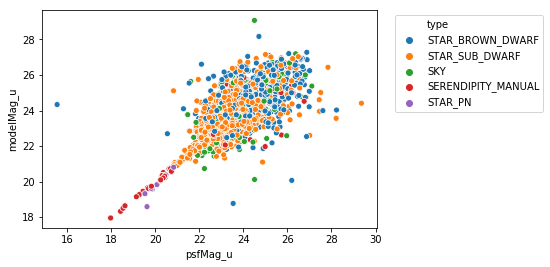

In [98]:
#범위축소해서 비교
s_train_df = last5_df[(last5_df.psfMag_u>10)&(last5_df.psfMag_u<30)]
s_train_df = s_train_df[(s_train_df.psfMag_g>10)&(s_train_df.psfMag_g<30)]

sns.scatterplot(x= 'psfMag_u', y= 'modelMag_u', hue = 'type', data = s_train_df)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [75]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

y = last5_df.type
X = last5_df.drop('type',axis = 1)

X.shape

(1855, 21)

In [76]:
resample_X, resample_y = sm.fit_resample(X,y)

In [77]:
resample_X.shape

(5770, 21)

In [78]:
new_train_last5 = pd.concat([resample_X,resample_y],axis = 1)
new_train_last5 = new_train_last5[train_df.columns]

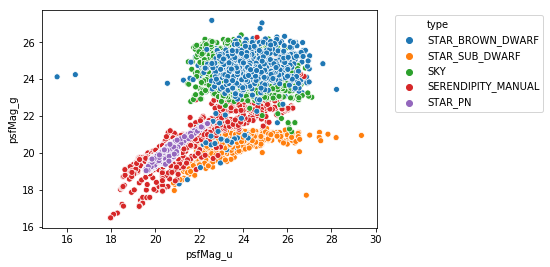

In [79]:
#범위축소해서 비교
s_train_df = new_train_last5[(new_train_last5.psfMag_u>10)&(new_train_last5.psfMag_u<30)]
s_train_df = s_train_df[(s_train_df.psfMag_g>10)&(s_train_df.psfMag_g<30)]

sns.scatterplot(x= 'psfMag_u', y= 'psfMag_g', hue = 'type', data = s_train_df)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [26]:
#concat oversample + 기존
new_train = pd.concat([not_last5_df,new_train_last5])
new_train.shape

(203906, 22)

## DATA Setting

In [28]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

new_train['type_num'] = new_train['type'].apply(lambda x: to_number(x, column_number))


In [29]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [30]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [31]:
train_df = add_minus_feature_all(new_train)
test_df = add_minus_feature_all(test_df,True)

In [32]:
train_df.shape,test_df.shape

((203906, 63), (10009, 61))

In [33]:
train_df.columns

Index(['type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'type_num', 'psfMag_u-g', 'psfMag_u-r', 'psfMag_u-i',
       'psfMag_u-z', 'psfMag_g-r', 'psfMag_g-i', 'psfMag_g-z', 'psfMag_r-i',
       'psfMag_r-z', 'psfMag_i-z', 'fiberMag_u-g', 'fiberMag_u-r',
       'fiberMag_u-i', 'fiberMag_u-z', 'fiberMag_g-r', 'fiberMag_g-i',
       'fiberMag_g-z', 'fiberMag_r-i', 'fiberMag_r-z', 'fiberMag_i-z',
       'petroMag_u-g', 'petroMag_u-r', 'petroMag_u-i', 'petroMag_u-z',
       'petroMag_g-r', 'petroMag_g-i', 'petroMag_g-z', 'petroMag_r-i',
       'petroMag_r-z', 'petroMag_i-z', 'modelMag_u-g', 'modelMag_u-r',
       'modelMag_u-i', 'modelMag_u-z', 'modelMag_g-r', 'modelMag_g-i',
       'modelMag_g-z', 'modelMag_r-i', 'modelMag_r-z

In [37]:
train_X = train_df.drop(columns=['type', 'type_num','fiberID'], axis=1)
train_y = train_df['type_num']
test_X = test_df.drop(columns = ['fiberID'])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [39]:
train_ds = lgb.Dataset(X_train, label = y_train)
test_ds = lgb.Dataset(X_test, label = y_test) 

In [40]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.05,
    'max_depth' : 12,
    'random_state' : 42
}

## Modeling

In [41]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 0.347028	Test's multi_logloss: 0.405815
[200]	Train's multi_logloss: 0.280994	Test's multi_logloss: 0.373331
[300]	Train's multi_logloss: 0.248401	Test's multi_logloss: 0.369138
[400]	Train's multi_logloss: 0.222806	Test's multi_logloss: 0.367913
[500]	Train's multi_logloss: 0.20224	Test's multi_logloss: 0.368537
Early stopping, best iteration is:
[406]	Train's multi_logloss: 0.221425	Test's multi_logloss: 0.367903


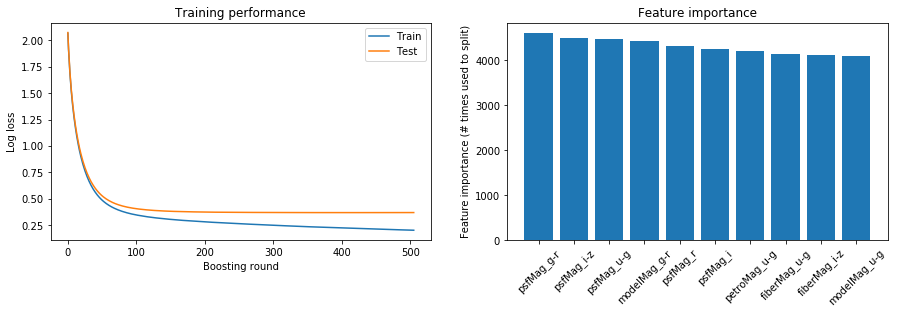

In [42]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [43]:
train_y_pred = lgmb_model.predict(X_test)
real_y_pred = lgmb_model.predict(test_X)

In [44]:
train_y_pred.shape

(61172, 19)

In [45]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.36790324073099373

In [46]:
lgmb_model.feature_importance()

array([2845, 3625, 4315, 4243, 3254, 3141, 3134, 3337, 3681, 2930, 3296,
       2540, 2711, 3246, 2835, 2937, 2524, 2404, 2489, 3205, 4463, 2923,
       2118, 1936, 4604, 2754, 2189, 4018, 2777, 4501, 4139, 3128, 2001,
       2015, 4082, 2585, 2039, 3976, 3322, 4119, 4214, 2849, 2140, 1952,
       3666, 2271, 1903, 3467, 2512, 3875, 4084, 2471, 2074, 1796, 4422,
       2265, 1921, 4025, 2906, 3942])

### feature_importance

In [47]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df.head(10)

,importance
psfMag_g-r,4604
psfMag_i-z,4501
psfMag_u-g,4463
modelMag_g-r,4422
psfMag_r,4315
psfMag_i,4243
petroMag_u-g,4214
fiberMag_u-g,4139
fiberMag_i-z,4119
modelMag_u-g,4084


### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0(STAR_WHITE_DWARF-2160),2(STAR_BROWN_DWARF-500),7(SERENDIPITY_DISTANT-4654),11(ROSAT_D-6580)
망한예측 : 12(STAR_PN-13),17(SERENDIPITY_MANUAL-61)

In [48]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [49]:
number_columns

{0: 'STAR_WHITE_DWARF',
 1: 'STAR_CATY_VAR',
 2: 'STAR_BROWN_DWARF',
 3: 'SERENDIPITY_RED',
 4: 'REDDEN_STD',
 5: 'STAR_BHB',
 6: 'GALAXY',
 7: 'SERENDIPITY_DISTANT',
 8: 'QSO',
 9: 'SKY',
 10: 'STAR_RED_DWARF',
 11: 'ROSAT_D',
 12: 'STAR_PN',
 13: 'SERENDIPITY_FIRST',
 14: 'STAR_CARBON',
 15: 'SPECTROPHOTO_STD',
 16: 'STAR_SUB_DWARF',
 17: 'SERENDIPITY_MANUAL',
 18: 'SERENDIPITY_BLUE'}

In [50]:
train_df.type.value_counts()

QSO                    49680
GALAXY                 37347
SERENDIPITY_BLUE       21760
SPECTROPHOTO_STD       14630
REDDEN_STD             14618
STAR_RED_DWARF         13750
STAR_BHB               13500
SERENDIPITY_FIRST       7132
ROSAT_D                 6580
STAR_CATY_VAR           6506
SERENDIPITY_DISTANT     4654
STAR_CARBON             3257
SERENDIPITY_RED         2562
STAR_WHITE_DWARF        2160
STAR_BROWN_DWARF        1154
SKY                     1154
STAR_PN                 1154
SERENDIPITY_MANUAL      1154
STAR_SUB_DWARF          1154
Name: type, dtype: int64

In [51]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,319,0,0,0,18,65,2,102,61,0,0,19,3,0,17,8,0,0,34
1,0,1881,0,0,0,2,1,1,16,0,1,3,0,0,0,0,3,0,44
2,0,0,279,54,0,0,0,0,0,0,12,0,0,0,0,0,0,1,0
3,0,0,59,611,0,0,0,0,3,0,95,0,0,0,0,0,0,1,0
4,0,0,0,0,4252,31,0,0,10,0,0,10,0,0,0,82,0,0,1
5,23,0,0,0,138,3681,2,54,58,0,0,5,0,0,0,79,0,0,10
6,2,12,0,0,8,0,10950,1,71,1,0,56,1,83,9,7,0,3,0
7,195,0,0,0,0,205,0,702,31,0,1,1,3,0,0,0,0,1,257
8,17,9,3,2,39,254,106,23,12950,3,9,182,2,38,69,7,14,2,1175
9,0,0,0,0,0,0,0,0,0,346,0,0,0,0,0,0,0,0,0


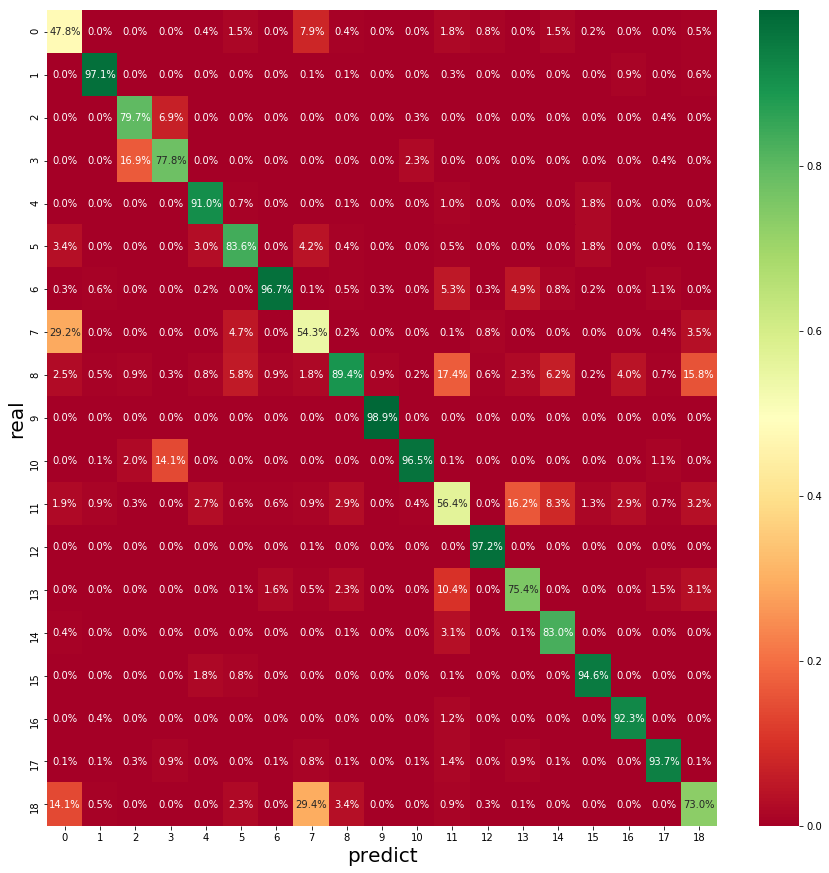

In [52]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [53]:
train_ds = lgb.Dataset(train_X, label = train_y)

In [54]:
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, verbose_eval=100)

In [58]:
train_y_pred = lgmb_model.predict(train_X)

In [55]:
y_pred = lgmb_model.predict(test_X)

In [56]:
y_pred

array([[7.75352905e-08, 2.04337802e-09, 8.80555199e-08, ...,
        2.11017374e-11, 4.79872924e-06, 8.15108115e-07],
       [2.51551946e-07, 3.28640225e-09, 5.93130507e-12, ...,
        1.13039935e-12, 6.99342332e-08, 1.17483804e-05],
       [5.86530156e-07, 6.05323749e-07, 1.01369548e-10, ...,
        1.20643657e-13, 2.69449961e-07, 8.73648702e-07],
       ...,
       [1.03809095e-05, 3.89636624e-06, 1.35536943e-11, ...,
        5.64255703e-12, 4.28368326e-08, 6.57230913e-02],
       [3.67830715e-08, 8.38926875e-10, 2.31616043e-12, ...,
        5.50590290e-13, 1.73811230e-09, 2.54733375e-04],
       [8.42248612e-06, 5.04463750e-11, 3.21133107e-12, ...,
        6.64575761e-14, 2.91624900e-10, 5.19790721e-07]])

In [57]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)